In [18]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 0

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [19]:
from ptmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split

x_normalizer, y_normalizer = get_normalizers("standard", n_normalizers=2)

x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

x_train_real = x_normalizer.inverse_transform(x_train)
x_test_real = x_normalizer.inverse_transform(x_test)
x_val_real = x_normalizer.inverse_transform(x_val)

In [20]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-4
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.0
input_dropout = 0.0
batch_norm = False
batch_norm_type = "ema"
output_activation = "linear"

num_mixtures = 2
encode_node_list = [8, 8]
decode_node_list = [8, 8]

# Make a history dict for storing metrics
history = {"loss": [], "val_loss": []}

In [21]:
from ptmelt.models import VariationalAutoEncoder
from torchinfo import summary
import torch
from torch import optim

# Create the vae
vae_model = VariationalAutoEncoder(
    num_features=n_features,
    num_outputs=None, # Not used in the VAE
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    output_activation=output_activation,
    encode_node_list=encode_node_list,
    decode_node_list=decode_node_list,
    latent_dim=n_info,
    # num_mixtures=num_mixtures,
    num_mixtures=1,
)

# Build the model
vae_model.build()
print(summary(vae_model, (1, n_features)))

# Create the optimizer
criterion = vae_model.get_loss_fn(loss="mse", reduction="mean")
optimizer = optim.Adam(vae_model.parameters(), lr=learn_rate)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoEncoder                   [1, 10]                   --
├─ModuleDict: 1-1                        --                        --
│    └─DenseBlock: 2-1                   [1, 8]                    --
│    │    └─ModuleDict: 3-1              --                        160
│    └─MixtureDensityOutput: 2-2         [1, 11]                   --
│    │    └─Linear: 3-2                  [1, 1]                    9
│    │    └─Softmax: 3-3                 [1, 1]                    --
│    │    └─Linear: 3-4                  [1, 5]                    45
│    │    └─Identity: 3-5                [1, 5]                    --
│    │    └─Linear: 3-6                  [1, 5]                    45
│    │    └─Identity: 3-7                [1, 5]                    --
│    └─DenseBlock: 2-3                   [1, 8]                    --
│    │    └─ModuleDict: 3-8              --                        120
│    └─Default

/Users/nwimer/miniconda3/envs/pt-melt/lib/python3.12/site-packages/ptmelt/models.py:192: UserWarning: Variational Autoencoders require the use of the VAELoss class. The loss function will be set to automatically.
  warnings.warn(


In [22]:
from torch.utils.data import DataLoader, TensorDataset

# Create the dataloaders
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(x_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(x_val).float())

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [31]:
# Fit the vae
vae_model.fit(
    train_dl=dataloader,
    val_dl=dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = vae_model.history

  5%|▌         | 16/300 [00:00<00:05, 48.80it/s]

Epoch 10, Loss: 1.0057, Val Loss: 0.9437
Epoch 20, Loss: 1.0056, Val Loss: 0.9814


 13%|█▎        | 39/300 [00:00<00:05, 49.29it/s]

Epoch 30, Loss: 1.0050, Val Loss: 1.0871


 17%|█▋        | 50/300 [00:01<00:05, 49.93it/s]

Epoch 40, Loss: 1.0047, Val Loss: 0.9300
Epoch 50, Loss: 1.0040, Val Loss: 1.0859


 23%|██▎       | 68/300 [00:01<00:04, 51.61it/s]

Epoch 60, Loss: 1.0042, Val Loss: 1.0076
Epoch 70, Loss: 1.0043, Val Loss: 0.9276


 29%|██▊       | 86/300 [00:01<00:04, 52.29it/s]

Epoch 80, Loss: 1.0039, Val Loss: 1.0187
Epoch 90, Loss: 1.0044, Val Loss: 1.0409


 35%|███▍      | 104/300 [00:02<00:03, 50.57it/s]

Epoch 100, Loss: 1.0042, Val Loss: 1.0492


 38%|███▊      | 115/300 [00:02<00:03, 46.86it/s]

Epoch 110, Loss: 1.0043, Val Loss: 1.0353


 42%|████▏     | 125/300 [00:02<00:03, 47.81it/s]

Epoch 120, Loss: 1.0049, Val Loss: 1.0116


 45%|████▌     | 136/300 [00:02<00:03, 49.86it/s]

Epoch 130, Loss: 1.0049, Val Loss: 0.9434
Epoch 140, Loss: 1.0041, Val Loss: 1.0753


 53%|█████▎    | 160/300 [00:03<00:02, 51.90it/s]

Epoch 150, Loss: 1.0043, Val Loss: 0.9607
Epoch 160, Loss: 1.0043, Val Loss: 1.1625


 59%|█████▉    | 178/300 [00:03<00:02, 47.61it/s]

Epoch 170, Loss: 1.0047, Val Loss: 1.0301


 63%|██████▎   | 188/300 [00:03<00:02, 48.00it/s]

Epoch 180, Loss: 1.0036, Val Loss: 1.0059


 67%|██████▋   | 200/300 [00:04<00:01, 50.07it/s]

Epoch 190, Loss: 1.0043, Val Loss: 0.9406
Epoch 200, Loss: 1.0052, Val Loss: 0.9950


 73%|███████▎  | 218/300 [00:04<00:01, 50.80it/s]

Epoch 210, Loss: 1.0045, Val Loss: 1.0030
Epoch 220, Loss: 1.0045, Val Loss: 0.9878


 79%|███████▊  | 236/300 [00:04<00:01, 53.32it/s]

Epoch 230, Loss: 1.0041, Val Loss: 0.9779
Epoch 240, Loss: 1.0043, Val Loss: 0.9644


 87%|████████▋ | 260/300 [00:05<00:00, 55.99it/s]

Epoch 250, Loss: 1.0043, Val Loss: 0.9548
Epoch 260, Loss: 1.0041, Val Loss: 1.0575


 93%|█████████▎| 278/300 [00:05<00:00, 56.32it/s]

Epoch 270, Loss: 1.0044, Val Loss: 1.0275
Epoch 280, Loss: 1.0042, Val Loss: 1.1362


100%|██████████| 300/300 [00:05<00:00, 51.35it/s]

Epoch 290, Loss: 1.0046, Val Loss: 0.9649
Epoch 300, Loss: 1.0036, Val Loss: 1.0175


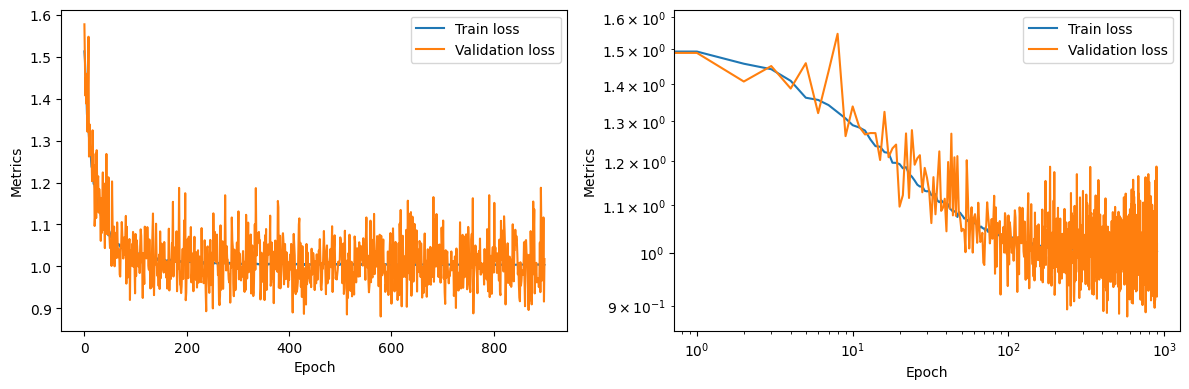

In [32]:
from ptmelt.utils.visualization import plot_history

plot_history(history, plot_log=True)

In [33]:
pred_train = vae_model(torch.from_numpy(x_train).float())[0].detach().numpy()
pred_val = vae_model(torch.from_numpy(x_val).float())[0].detach().numpy()
pred_test = vae_model(torch.from_numpy(x_test).float())[0].detach().numpy()


print(x_train[:5])
print(pred_train[:5])


[[-0.58444178  0.36655853 -1.39407275 -2.3880297   1.1805862   0.52421764
  -0.42073517 -0.26044401  0.41020171  0.90952324]
 [ 0.398381    0.22896049 -0.62223451  0.17027019 -0.68632199  0.03217698
   0.9113717  -0.63856107 -0.87607518  0.77779499]
 [ 0.36211328  0.55475105  1.84779558 -2.49231764  1.03894551 -0.78091693
  -0.50661096 -1.03586934 -0.22220268  1.18322594]
 [ 0.24075883 -0.45505917 -1.25006467 -1.22356872  0.81248231 -0.85491035
   0.15764571  0.08243735  0.14384999  0.39996834]
 [-1.5213876  -0.3032595  -0.73922273 -0.31941116 -0.1013174   0.48835497
   0.86624646  0.03058414  0.04296999  0.58316821]]
[[ 0.00871804  0.00098615  0.00287628  0.00108391 -0.00996383  0.03031022
   0.02670248  0.00553249  0.00753816  0.00095688]
 [ 0.01426451  0.01024268  0.0055856   0.00215778 -0.00973544  0.03001442
   0.022186    0.0091785   0.01017447 -0.00278002]
 [ 0.01209525 -0.02506131  0.02277946  0.03046008  0.00366564  0.02497113
   0.01671325  0.00391296  0.02296474 -0.02520328]

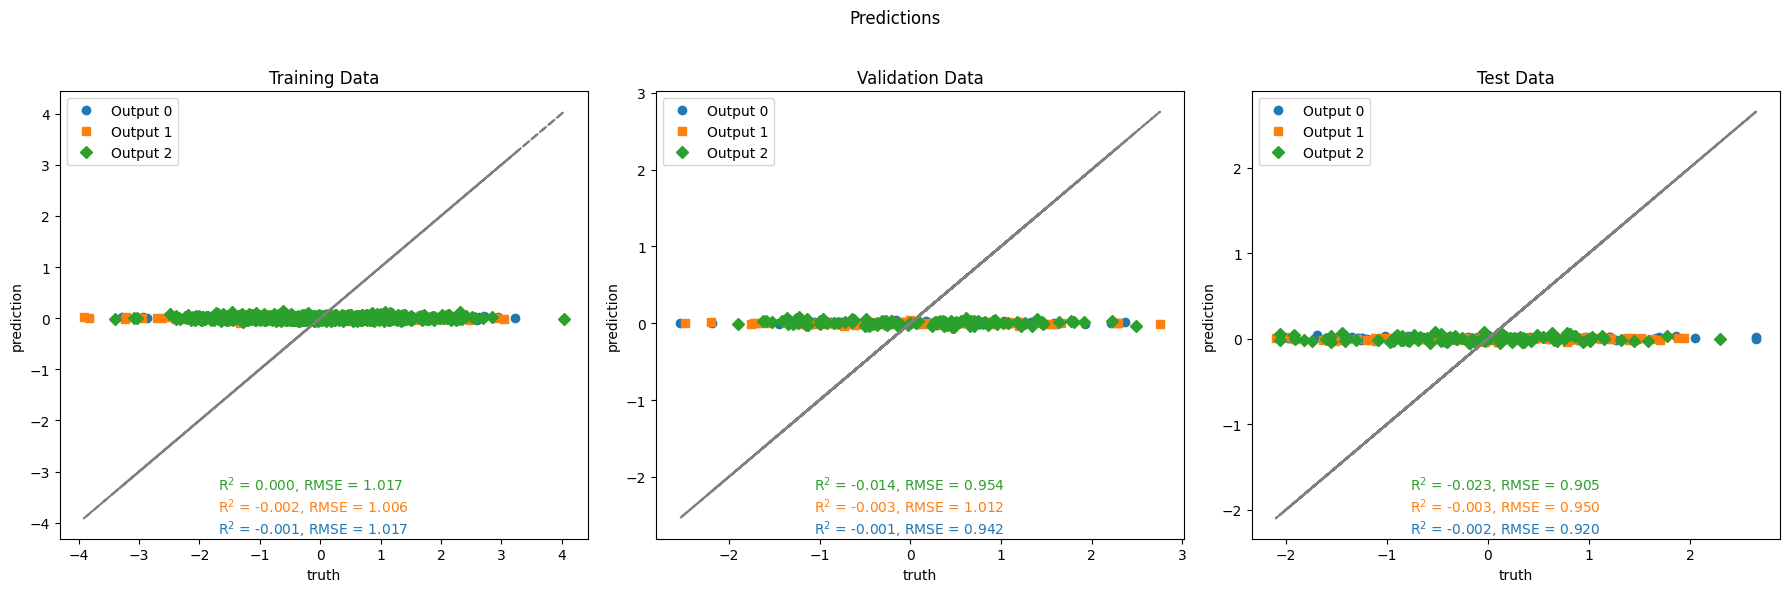

In [34]:
from ptmelt.utils.visualization import plot_predictions

plot_predictions(pred_train, x_train, pred_val, x_val, pred_test, x_test)